# Import Data

In [1]:
import tensorflow
import keras
import numpy as np
np.random.seed(1248)

Using TensorFlow backend.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [4]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [5]:
x = pd.read_csv("../data/buffer_overflow_graph_embeddings.csv.gz")
x['testcase_ID'] = x['type']
del x['type']
x = x.sort_values("testcase_ID")

In [6]:
y = labels['bug']

In [7]:
testcase_IDs = x['testcase_ID']
x = x.drop('testcase_ID', axis='columns')

In [8]:
import pickle

with open('../data/x-train-binary','rb') as f:
    x_train = pickle.load(f)
    
with open('../data/y-train-binary','rb') as f:
    y_train = pickle.load(f)
    
with open('../data/x-test-binary','rb') as f:
    x_test = pickle.load(f)
    
with open('../data/y-test-binary','rb') as f:
    y_test = pickle.load(f)

In [9]:
x_train_indices = x_train.index.tolist()
x_test_indices = x_test.index.tolist()
testcase_train = testcase_IDs.iloc[x_train_indices]
testcase_test = testcase_IDs.iloc[x_test_indices]

In [10]:
# with open ('../data/testcase-id-train', 'wb') as f:
#     pickle.dump(f)

# [Neural tutorial](https://towardsdatascience.com/neural-networks-from-scratch-easy-vs-hard-b26ddc2e89c7)

In [11]:
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam

In [12]:
model = Sequential()

model.add(Dense(128, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 33,153
Trainable params: 33,153
Non-trainable params: 0
_________________________________________________________________


In [14]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/graph2vec-architecture-dnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

ModuleNotFoundError: No module named 'pydot'

In [26]:
model.fit(x_train, y_train, epochs=50, batch_size=64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
17201/17201 [==============================] - 1s 58us/step - loss: 0.6729 - acc: 0.5685
Epoch 2/50
17201/17201 [==============================] - 1s 50us/step - loss: 0.6050 - acc: 0.6875
Epoch 3/50
17201/17201 [==============================] - 1s 48us/step - loss: 0.5478 - acc: 0.7355
Epoch 4/50
17201/17201 [==============================] - 1s 57us/step - loss: 0.4947 - acc: 0.7707
Epoch 5/50
17201/17201 [==============================] - 1s 84us/step - loss: 0.4511 - acc: 0.7973
Epoch 6/50
17201/17201 [==============================] - 1s 48us/step - loss: 0.4192 - acc: 0.8157
Epoch 7/50
17201/17201 [==============================] - 1s 51us/step - loss: 0.3826 - acc: 0.8394
Epoch 8/50
17201/17201 [==============================] - 1s 45us/step - loss: 0.3470 - acc: 0.8548
Epoch 9/50
17201/17201 [==============================] - 1s 49us/step - loss: 0.3105 - acc: 0.8735
Epoch 10/50
17201/17201 [===========================

In [27]:
import pickle

In [ ]:
with open('../data/dense-model-binary','wb') as f:
    pickle.dump(model,f)

In [28]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 54us/step


[0.09323040442227264, 0.9539641943872599]

In [29]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [30]:
y_predict= model.predict(x_test)

In [31]:
import numpy as np

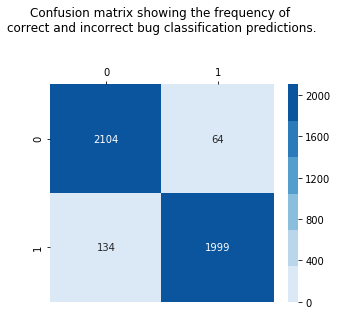

In [32]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

confusion_figure.savefig('../images/baseline_conf_matrix')

In [33]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict)).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [34]:
fpr_nn

0.031022782355792537

In [35]:
fnr_nn

0.05987488829311886

In [36]:
from sklearn.metrics import roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve((y_test.values+0), y_predict)
precision, recall, thresholds = precision_recall_curve((y_test.values+0), y_predict)

In [37]:
auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score((y_test.values+0), y_predict)
pr_auc = auc(recall, precision)
f1 = f1_score((y_test.values+0), np.rint(y_predict))
mcc = matthews_corrcoef((y_test.values+0), np.rint(y_predict))

In [38]:
print('PR AUC: %.3f' % pr_auc)
print('ROC AUC: %.3f' % roc_auc)
print('MCC: %.3f' % mcc)
print('F1: %.3f' % f1)

PR AUC: 0.994
ROC AUC: 0.994
MCC: 0.908
F1: 0.953


In [39]:
with open('../data/baseline-roc', 'wb') as f:
    pickle.dump(auc_keras, f)

with open('../data/baseline-pr', 'wb') as f:
    pickle.dump(roc_auc, f)

In [74]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

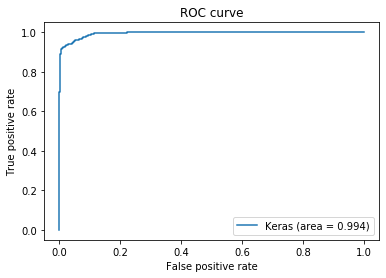

<Figure size 432x288 with 0 Axes>

In [75]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('../images/baseline_roc_curve')

### Train / Test / Validation Split

In [24]:
with open('../data/x-train-binary-for-3-way-split','rb') as f:
    x_train1 = pickle.load(f)
    
with open('../data/y-train-binary-for-3-way-split','rb') as f:
    y_train1 = pickle.load(f)
    
with open('../data/x-val-binary','rb') as f:
    x_val = pickle.load(f)
    
with open('../data/y-val-binary','rb') as f:
    y_val = pickle.load(f)

### Fitting Model with 3-way Split for Validation

In [25]:
model.fit(x_train1, y_train1, validation_data = (x_val, y_val), epochs=50, batch_size=64)

Train on 15050 samples, validate on 2151 samples
Epoch 1/50
15050/15050 [==============================] - 1s 78us/step - loss: 0.0874 - acc: 0.9554 - val_loss: 0.0837 - val_acc: 0.9530
Epoch 2/50
15050/15050 [==============================] - 2s 115us/step - loss: 0.0870 - acc: 0.9569 - val_loss: 0.0909 - val_acc: 0.9498
Epoch 3/50
15050/15050 [==============================] - 1s 86us/step - loss: 0.0842 - acc: 0.9583 - val_loss: 0.0797 - val_acc: 0.9572
Epoch 4/50
15050/15050 [==============================] - 1s 84us/step - loss: 0.0840 - acc: 0.9585 - val_loss: 0.0977 - val_acc: 0.9489
Epoch 5/50
15050/15050 [==============================] - 1s 79us/step - loss: 0.0878 - acc: 0.9577 - val_loss: 0.0951 - val_acc: 0.9489
Epoch 6/50
15050/15050 [==============================] - 2s 118us/step - loss: 0.0843 - acc: 0.9593 - val_loss: 0.0788 - val_acc: 0.9563
Epoch 7/50
15050/15050 [==============================] - 2s 139us/step - loss: 0.0861 - acc: 0.9561 - val_loss: 0.1125 - val_a

In [26]:
model.evaluate(x_test,y_test)

4301/4301 [==============================] - 0s 68us/step


[0.08080741595255998, 0.9544292025110439]

In [27]:
y_predict1= model.predict(x_test)

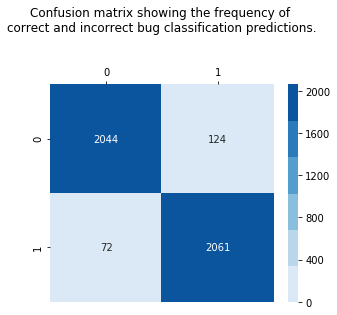

In [28]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(y_test, np.rint(y_predict1)), 
    
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 4)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [32]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, np.rint(y_predict1)).flatten().tolist()

fpr_nn1 = fp/(fp+tp)
fnr_nn1 = fn/(fn+tn)

In [33]:
fpr_nn1

0.056750572082379866

In [34]:
fnr_nn1

0.034026465028355386